In [1]:
%matplotlib notebook

import numpy as np
from scipy.integrate import solve_ivp
from numpy import pi
import matplotlib.pyplot as plt
from arc import Rubidium87
from scipy.optimize import curve_fit

from basics import *
from rabi_frequencies import *
from atomic_physics import *

rb = Rubidium87()

# Rb Constants

In [2]:
# dipole moments
ge_d = 3.584e-29  # <J=1/2||er||J'=3/2> [C*m] from Steck
er_d = lambda nr: rb.getReducedMatrixElementJ(5,1,3/2,nr,2,5/2)*e*ao

i_rb = 3/2  # rubidium87 nuclear spin

DHF = hf_splittings(
    h*84.7185e6,  # A_5P3/2 (Hz)
    h*12.4965e6,  # B_5P3/2 (Hz)
    3/2,
    3/2,
    com=True
)

In [3]:
def rabi_ge(e_field, pol_ar, fp, mp):
    """
    rabi frequency between states |5S1/2;2,0> and |5p3/2;fp,mp> given field strengt
    """
    ge_d_hf = dipole_rme_hf(ge_d, 1/2, 2, 3/2, fp, i_rb)
    return dipole_rabi_frequency(e_field, pol_ar, ge_d_hf, 2,0,fp,mp)

def rabi_er(p, w, pol_ar, f, mf, mr):
    """
    rabi frequency between states |5P3/2;f,mf> and |nrD5/2;mr> from HF basis to FS basis. given beam 
        paramenters
    """
    return dipole_hf_to_fs(
        electric_field_strength(p,w),
        pol_ar,
        er_d(nr),
        3/2,
        f,
        mf,
        5/2,
        mr,
        i_rb
    )

def zeeman_e(B, f, mf):
    """
    First order Zeeman shift on the state |5P3/2,f,mf> in Rb87
    """
    if f==0:
        return 0
    j=3/2
    i = i_rb
    g_j = 1.3362
    g_i = -0.00099514
    j_cont = g_j * (f * (f + 1) + j * (j + 1) - i * (i + 1))
    i_cont = g_i * (f * (f + 1) - j * (j + 1) + i * (i + 1))
    gf = (j_cont + i_cont) / (2 * f * (f + 1))
    # print(gf)
    # print(j_cont, i_cont)
    return mub*B*gf*mf

def zeeman_r(B,nr,mr):
    """
    First order Zeeman shift on the state |nrD5/2,mr>
    # TODO: Diamagnetic term?
    """
    gj = 6/5
    return mub*B*gj*mr

# Experiment Parameters

In [49]:
# p_ge = 50e-3  # W
p_er = 0.9*0.014  # W
# w_ge = 15e-6  # m
e_field_ge = 3797.8949279380545  # V/m
w_er = 4e-6  # m
pol_ge = SphericalVector([0,1,0])  # sigma+ polarized
pol_er = SphericalVector([0,1,0])  # sigma+ polarized
# k_ar = SphericalVector([1,0,0], spherical_basis=False)  # X polarized
nr = 84  # Target Rydberg State
phi_ge = 0  # phase on 684nm field
phi_er = 0  # phase of 595nm field

bias_B = 3 * gauss # bias field in the z-direction

# Laser detunings
detuning = -2*pi*(2.1e9 - 266.651e6)  # Detuning from the ground-excited transition (excited state com) (Hz)

# detuning = 2*pi*85.1e6
delta = np.array([detuning - DET for DET in DHF])
little_delta = zeeman_r(bias_B,nr,5/2)/hb+2*pi*.106e6

f_list = range(int(abs(i_rb-3/2)),int(i_rb+3/2)+1,1)
me_list = [-1,0,1]
jr = 5/2
mr_list = np.arange(-jr,jr+1,1)


mrs = np.arange(-jr,jr+1,1)

In [51]:
Oge = np.zeros((max(f_list)+1,len(me_list)),dtype=complex)
Oer = np.zeros((max(f_list)+1,len(me_list),len(mr_list)),dtype=complex)

for fp in f_list:
    for mp in me_list:
        Oge[fp,mp] = rabi_ge(e_field_ge, pol_ge, fp, mp)
        for i, mr in enumerate(mr_list):
            Oer[fp,mp,i] = rabi_er(p_er, w_er, pol_er, fp, mp, mr)


In [52]:
def psi_sch(t, psi, hamiltonian):
    return -1j*np.dot(psi, hamiltonian)

dim = 1+len(f_list)*len(me_list)+len(mr_list)  # dimension of our hilbert space
find = lambda f, mf: 3*f + mf + 2
ryd_ind = lambda mr: int(mr + jr)+find(max(f_list),max(me_list))+1

# Initialize hamiltonian and state
H = np.zeros((dim,dim),dtype=complex)
psi_0 = np.zeros(dim, dtype=complex)
psi_0[0] = 1

for f in f_list:
    for mf in me_list:
        H[0,find(f,mf)] = Oge[f,mf]/2
        H[find(f,mf),0] = H[0,find(f,mf)].conjugate()
        
        H[find(f,mf),find(f,mf)] = delta[f]-zeeman_e(bias_B, f, mf)/hb
        
        for i, mr in enumerate(mr_list):
            H[find(f,mf), ryd_ind(mr)] = Oer[f,mf,i]/2
            H[ryd_ind(mr), find(f,mf)] = H[find(f,mf), ryd_ind(mr)].conjugate()
            H[ryd_ind(mr), ryd_ind(mr)] = little_delta-zeeman_r(bias_B,nr,mr)/hb

<IPython.core.display.Javascript object>


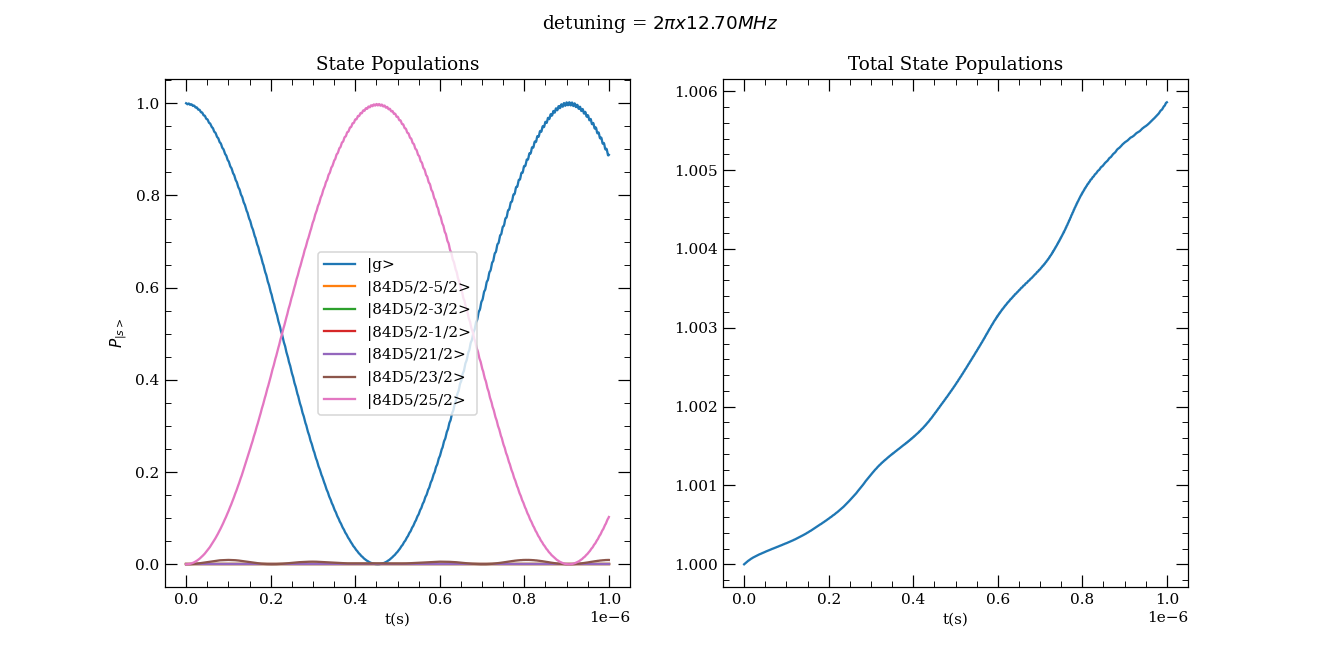

In [55]:
ts = np.linspace(0,1e-6,1000)
# detunings = np.linspace(-10e6,10e6,31)
# P_r = np.zeros((len(detunings),len(mr_list)),dtype=float)
# ys = np.zeros((len(psi_0),len(detunings),len(ts)),dtype=complex)
# for i, detuning in enumerate(detunings):
# for j, mr in enumerate(mr_list):
#     H[ryd_ind(mr), ryd_ind(mr)] = little_delta-zeeman_r(bias_B,nr,mr)/hb+detuning
sol = solve_ivp(
    lambda t, y : psi_sch(t, y, H),
    (min(ts),max(ts)),
    psi_0,
    t_eval = ts
)
ys[:,i,:] = sol.y
# P_r[i,:] = np.abs(sol.y[-len(mr_list):,1])**2
fig,ax = plt.subplots(1,2,figsize = (12,6))
ax[0].plot(ts,np.abs(sol.y[0])**2,label = f"|g>")
for mr in mr_list:
    ax[0].plot(ts,np.abs(sol.y[ryd_ind(mr)])**2,label = f"|{nr}D5/2{int(2*mr)}/2>")
ax[0].legend()
ax[0].set_title(f"State Populations")
ax[1].set_title(f"Total State Populations")
ax[0].set_xlabel(f"t(s)")
ax[0].set_ylabel("$P_{|s>}$")
ax[1].plot(ts,(np.abs(sol.y)**2).sum(0))
ax[1].set_xlabel(f"t(s)")
fig.suptitle(f"detuning = $2\pi x {little_delta/(2*pi)*1e-6:.2f}MHz$")
fig.show()

<IPython.core.display.Javascript object>


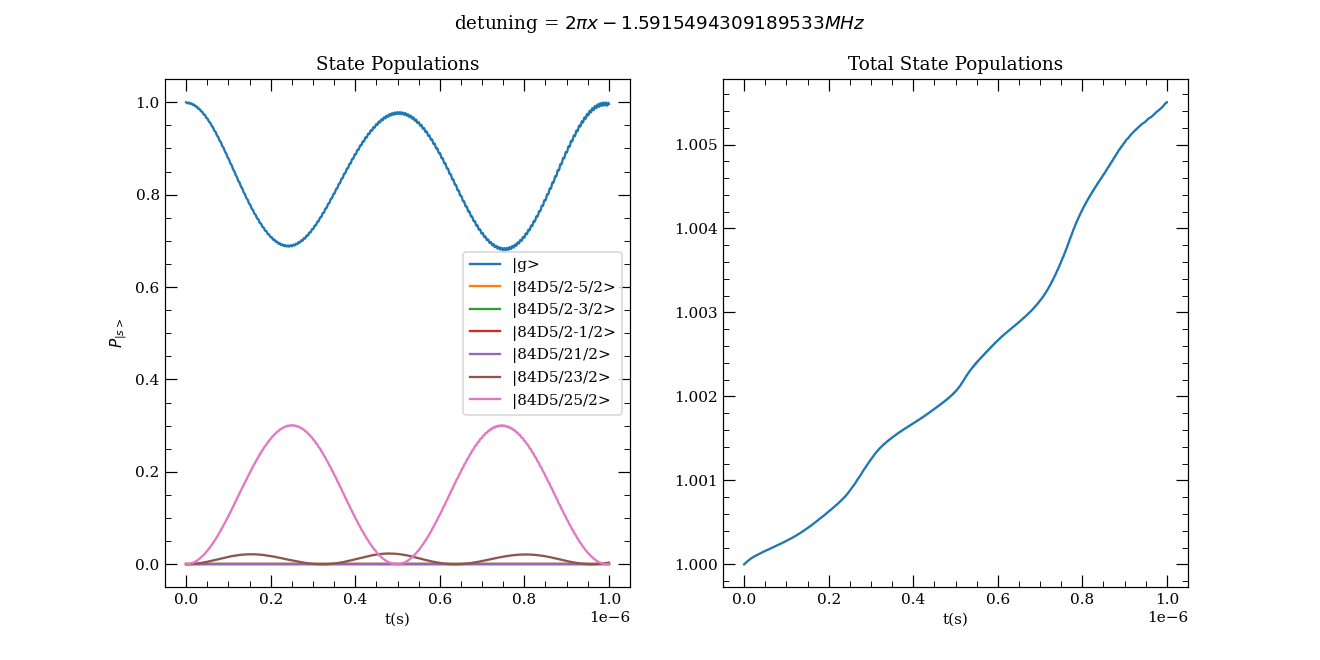

<IPython.core.display.Javascript object>


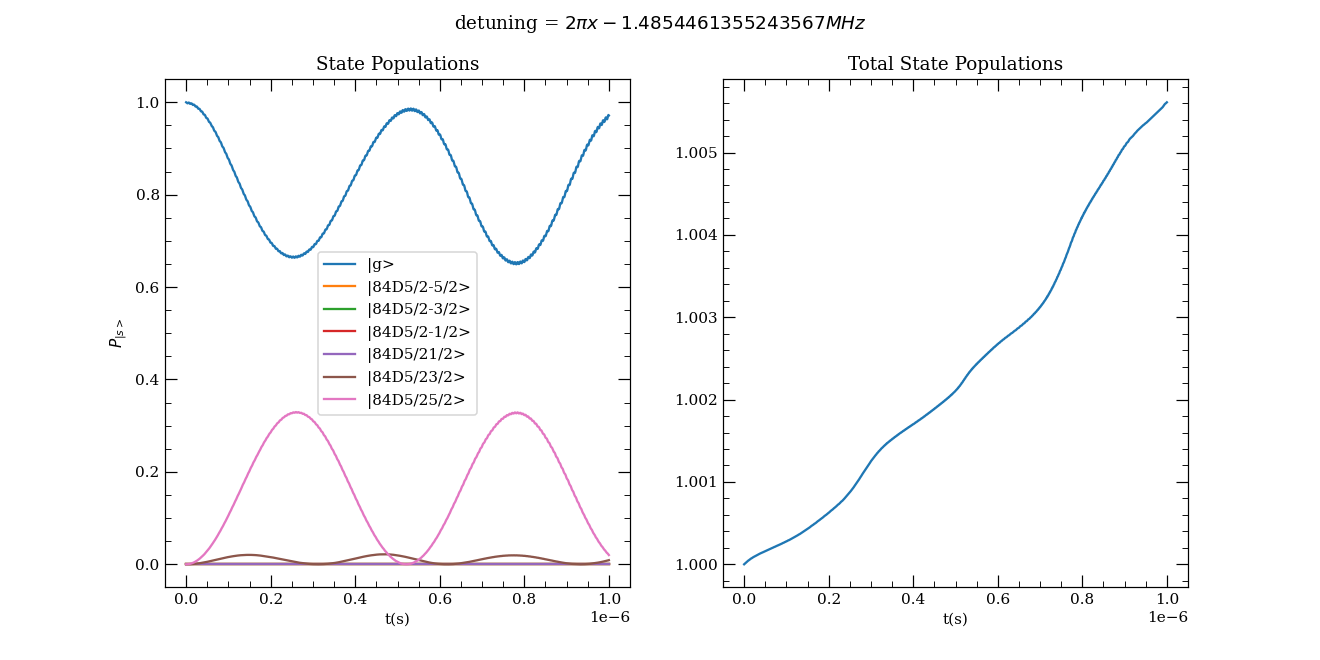

<IPython.core.display.Javascript object>


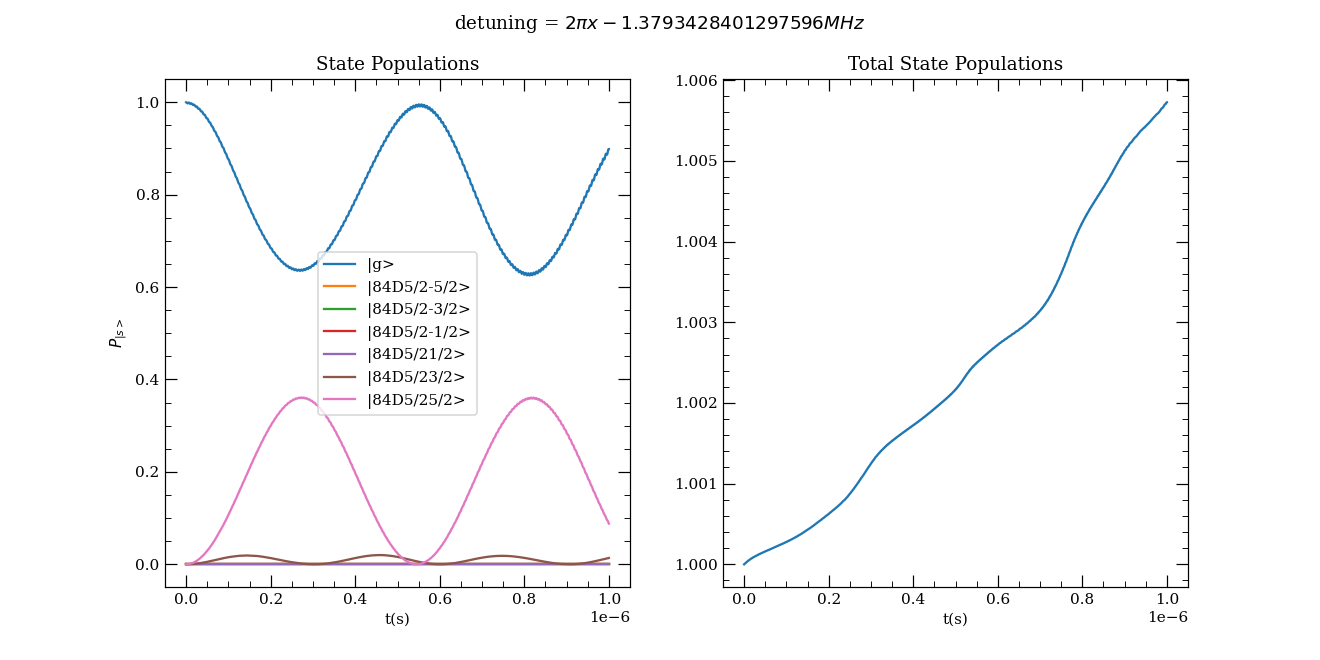

<IPython.core.display.Javascript object>


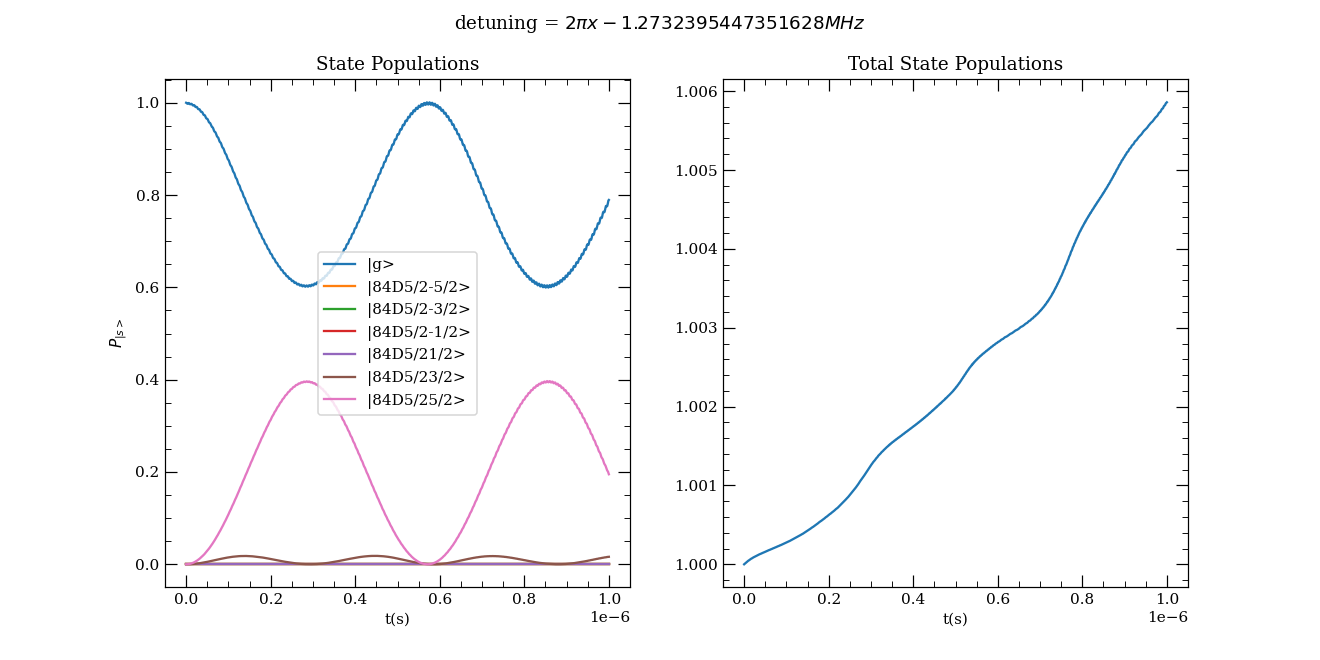

<IPython.core.display.Javascript object>


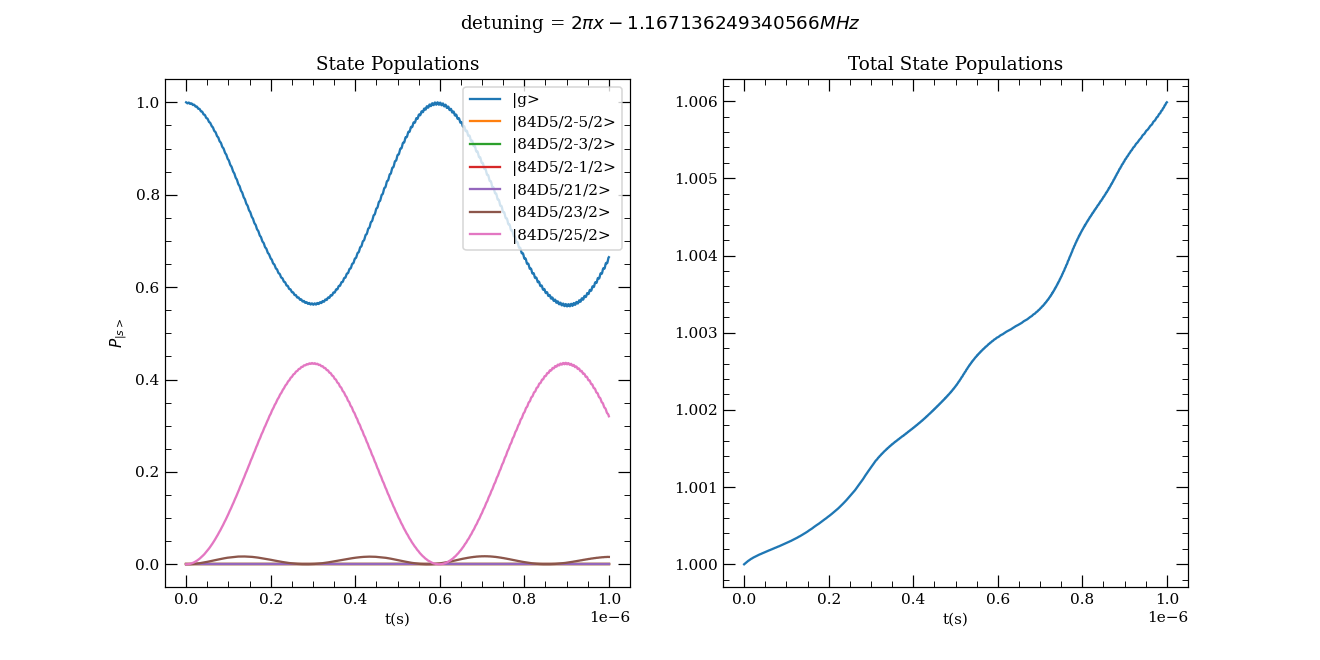

<IPython.core.display.Javascript object>


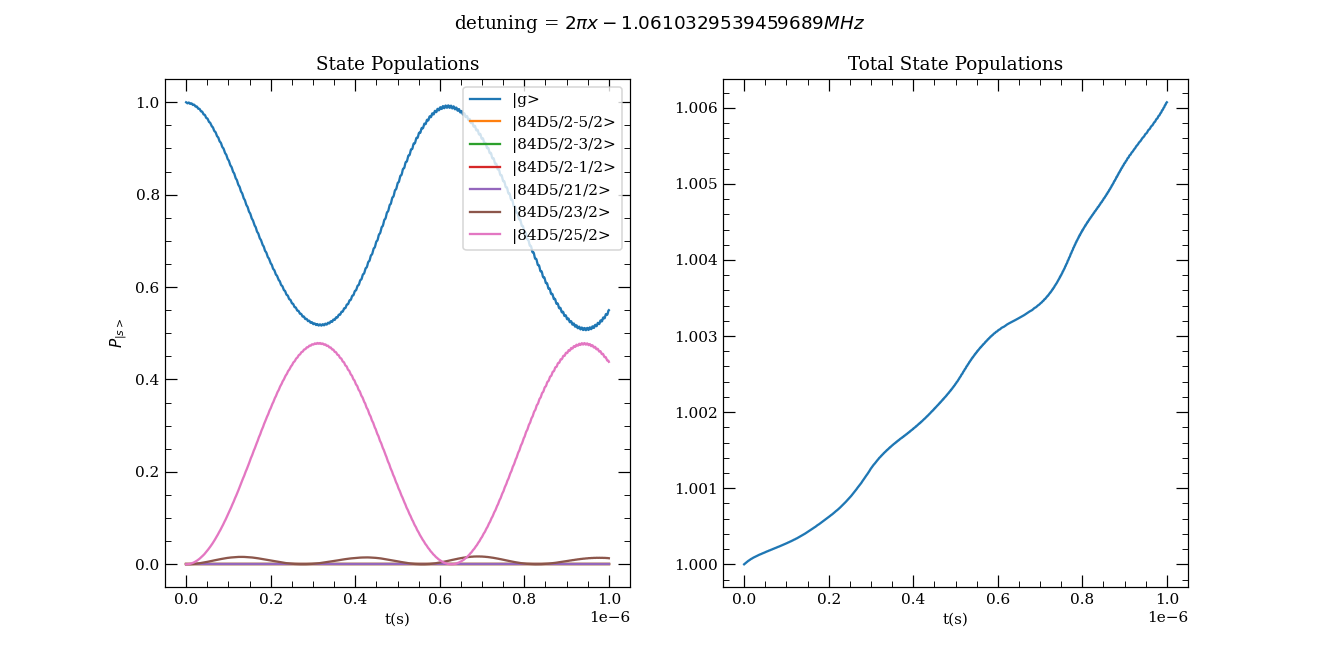

<IPython.core.display.Javascript object>


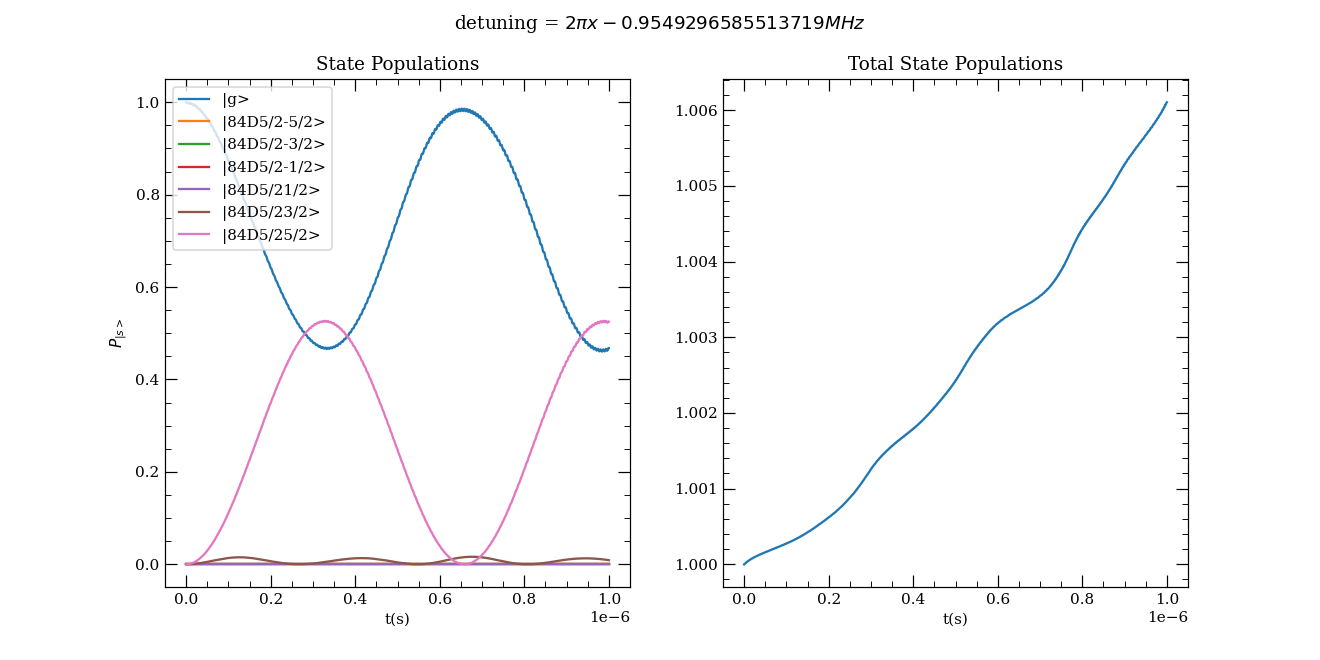

<IPython.core.display.Javascript object>


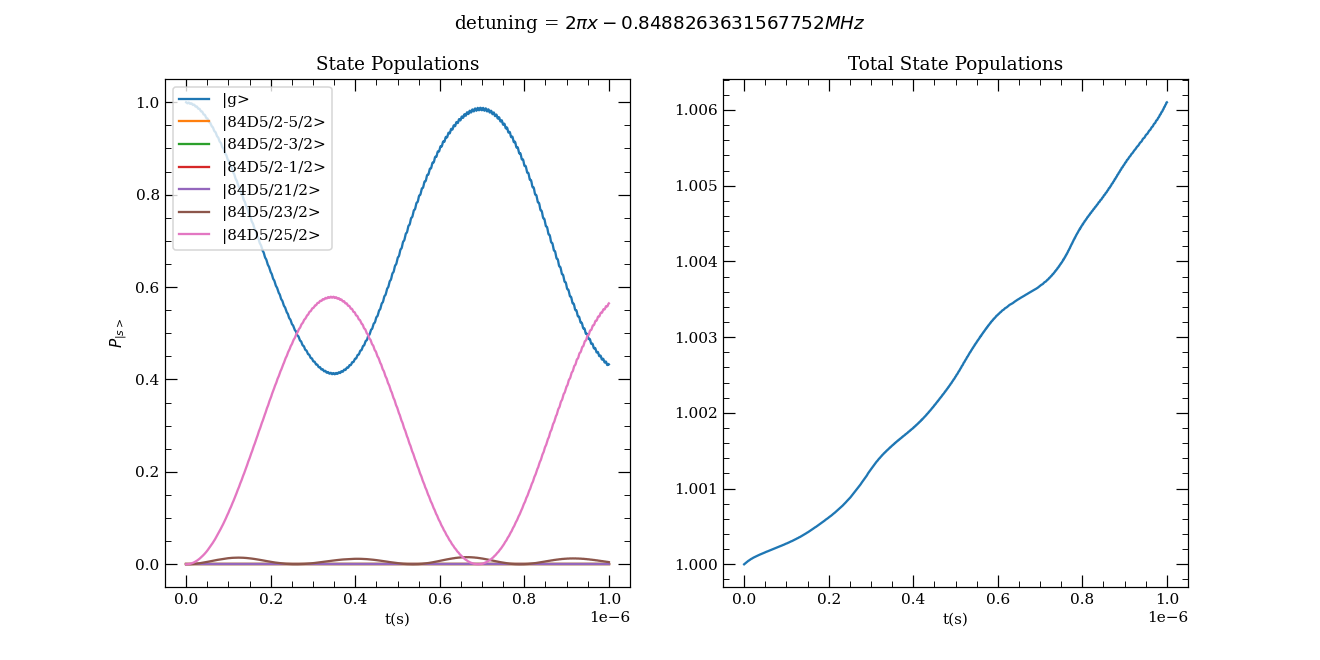

<IPython.core.display.Javascript object>


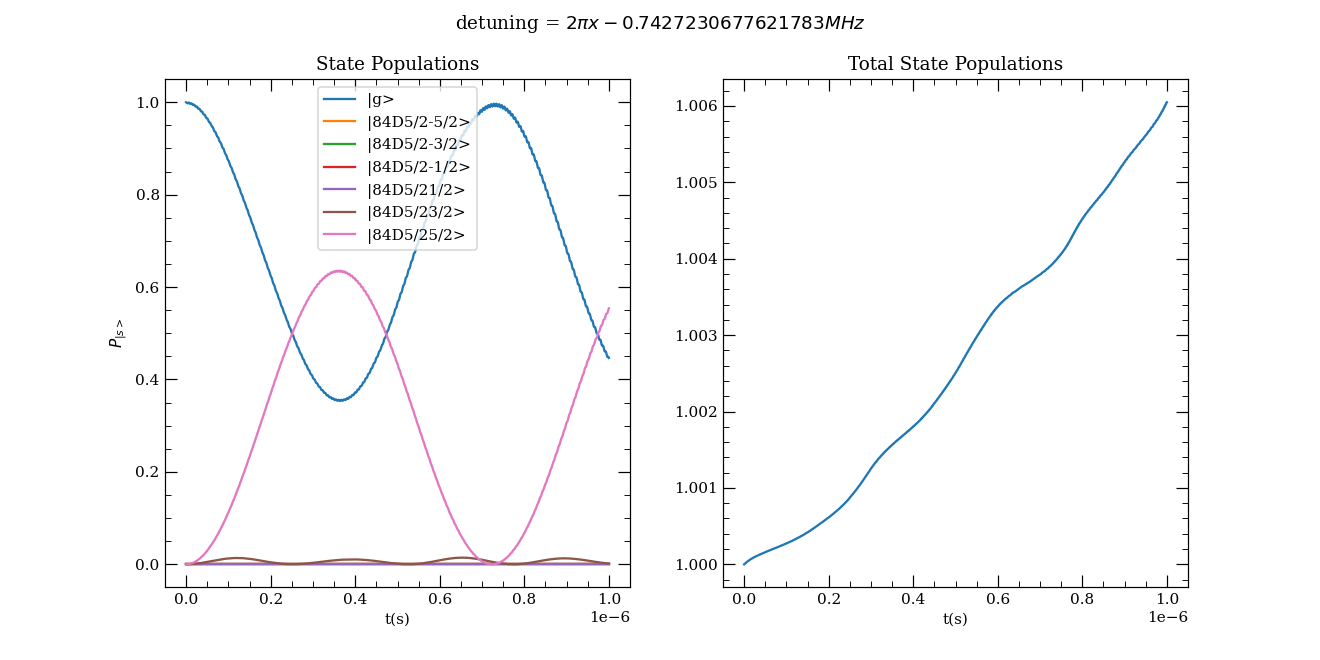

<IPython.core.display.Javascript object>


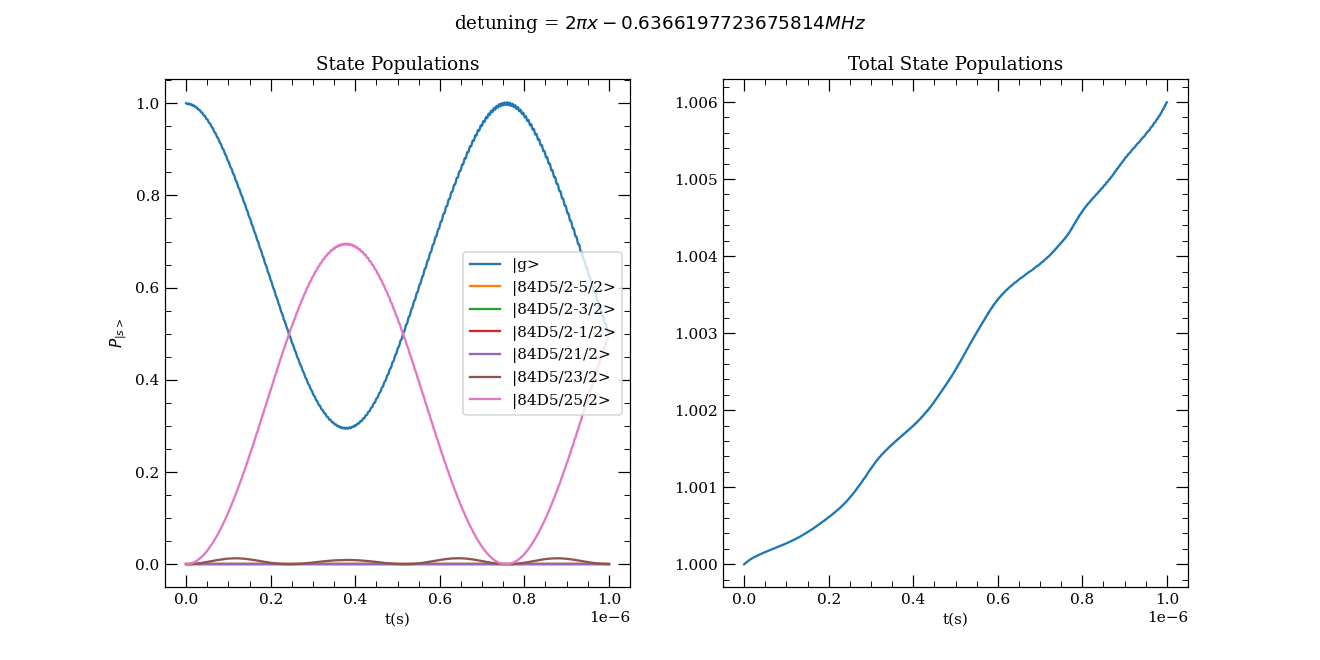

<IPython.core.display.Javascript object>


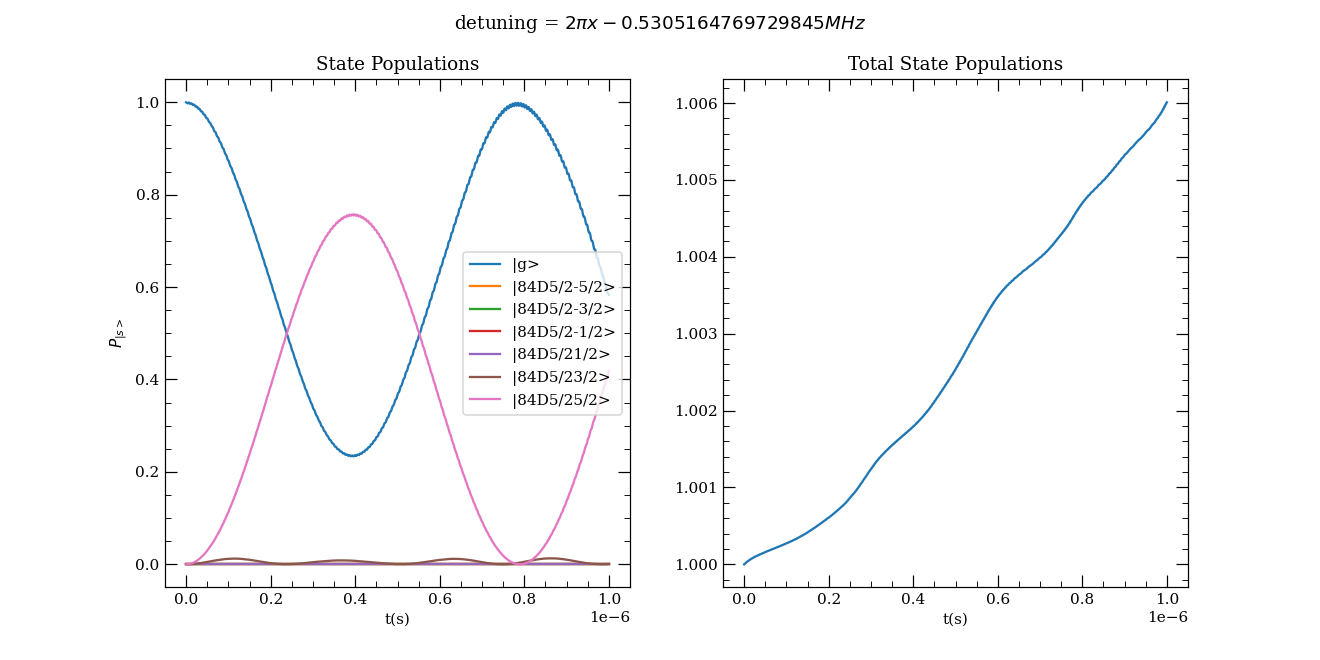

<IPython.core.display.Javascript object>


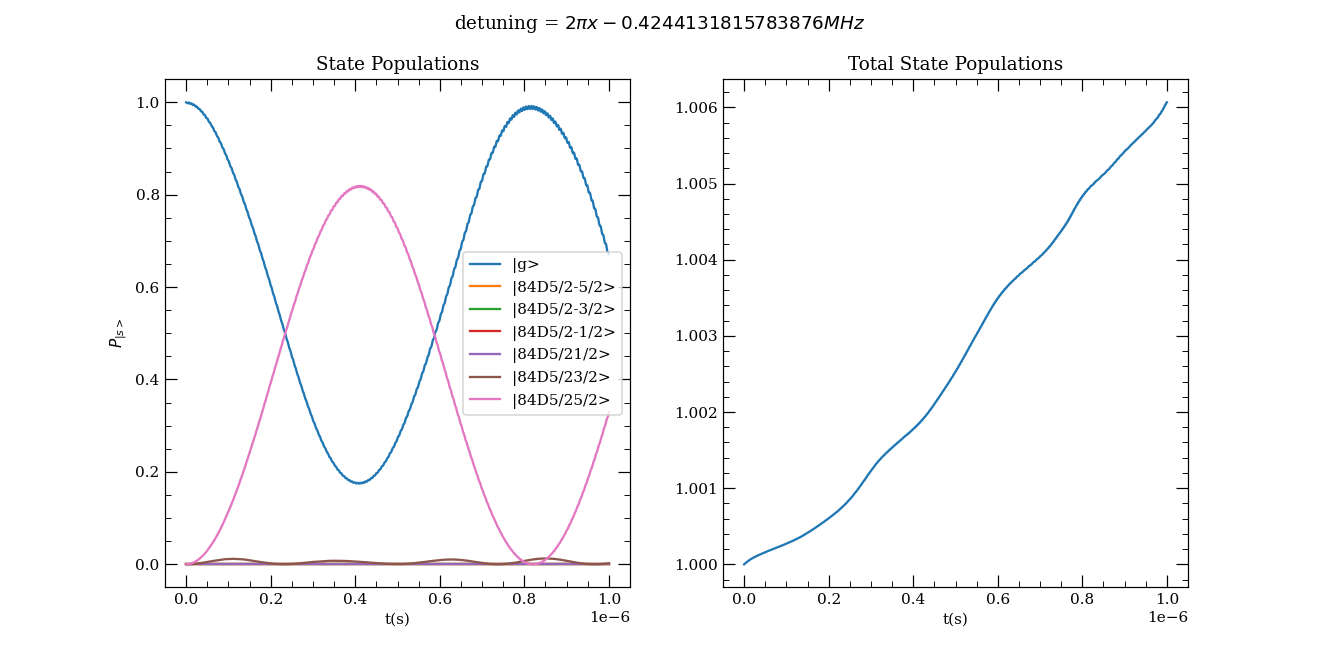

<IPython.core.display.Javascript object>


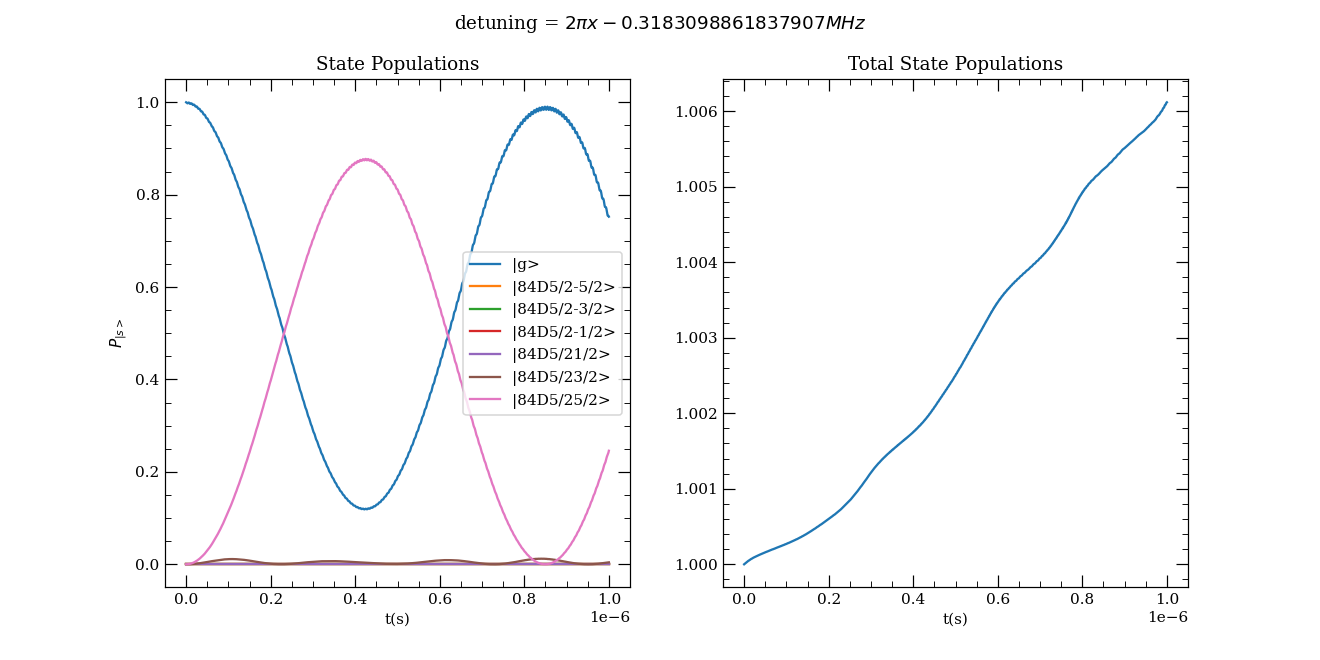

<IPython.core.display.Javascript object>


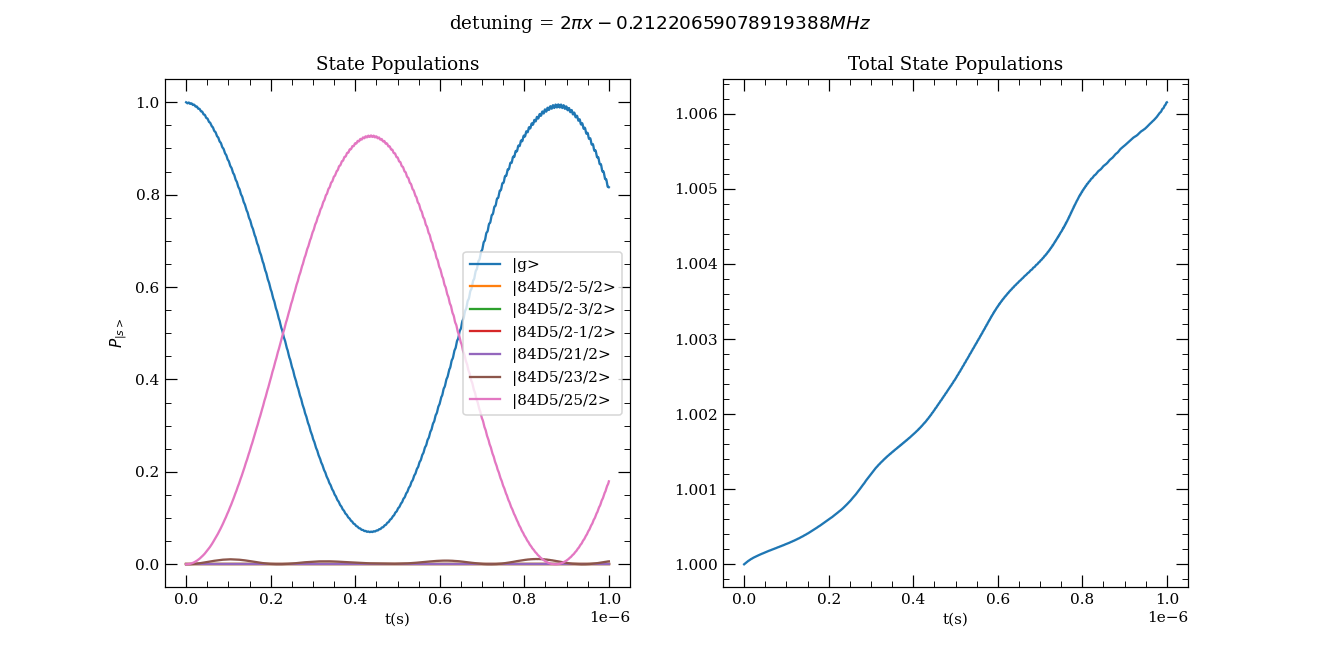

<IPython.core.display.Javascript object>


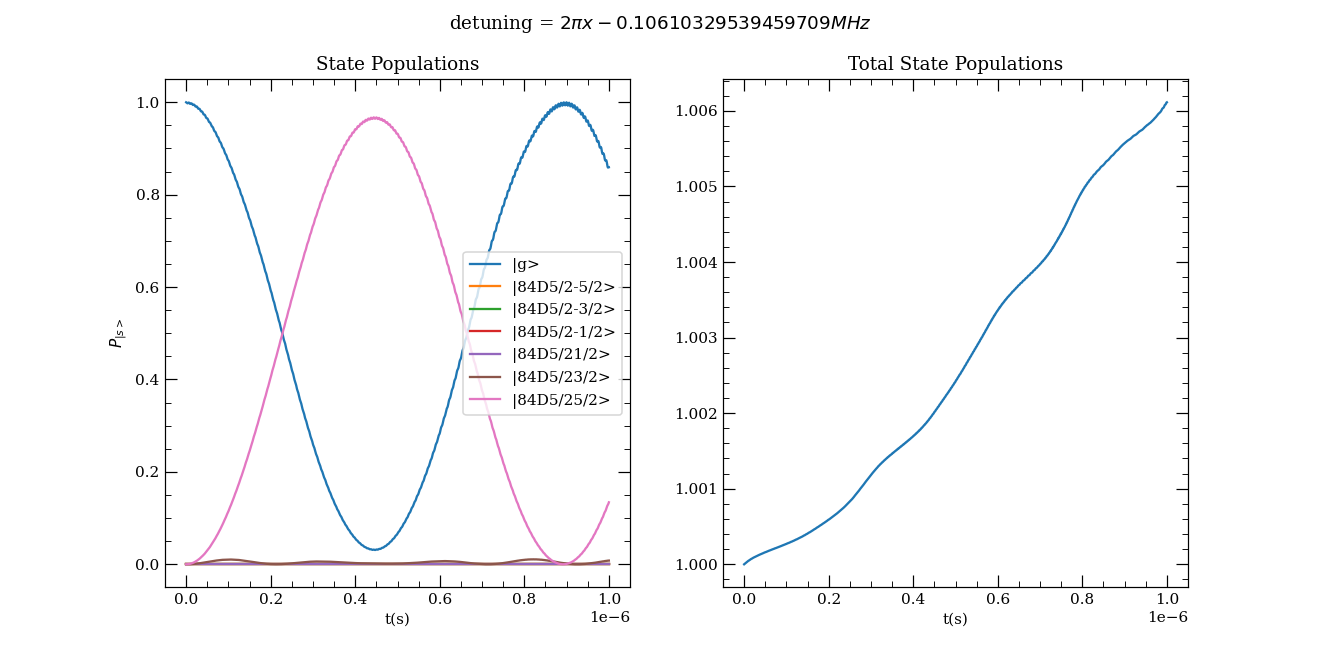

<IPython.core.display.Javascript object>


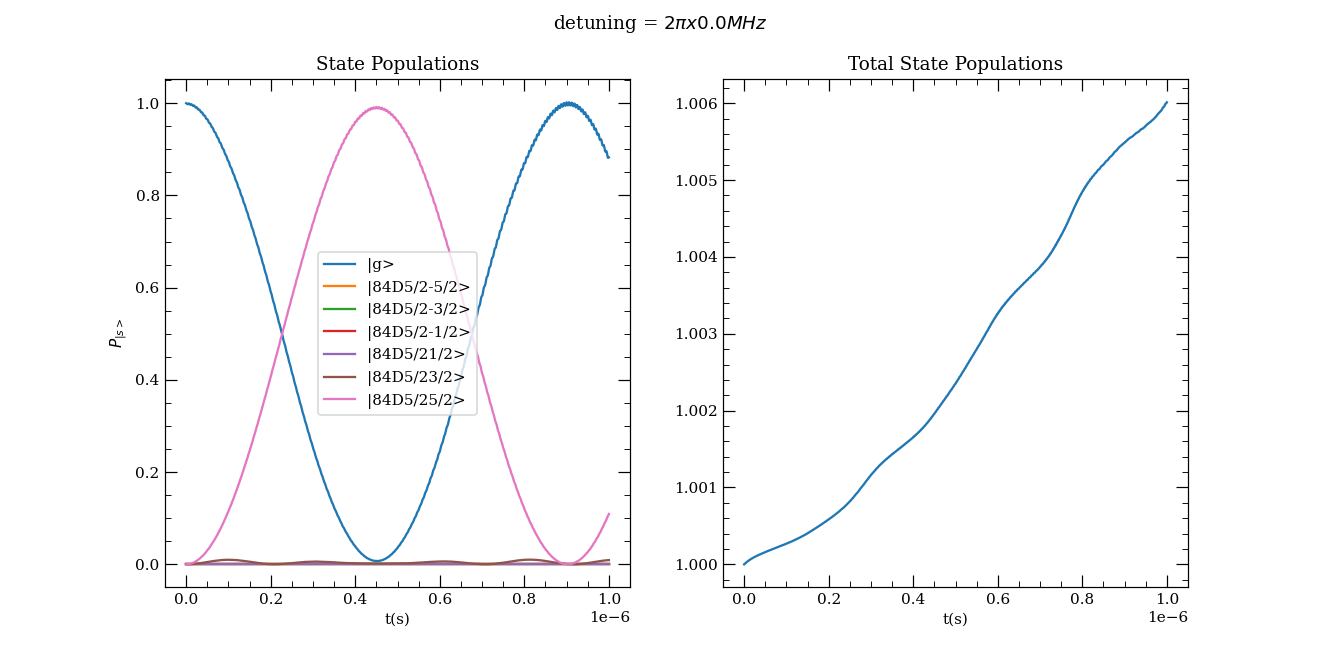

<IPython.core.display.Javascript object>


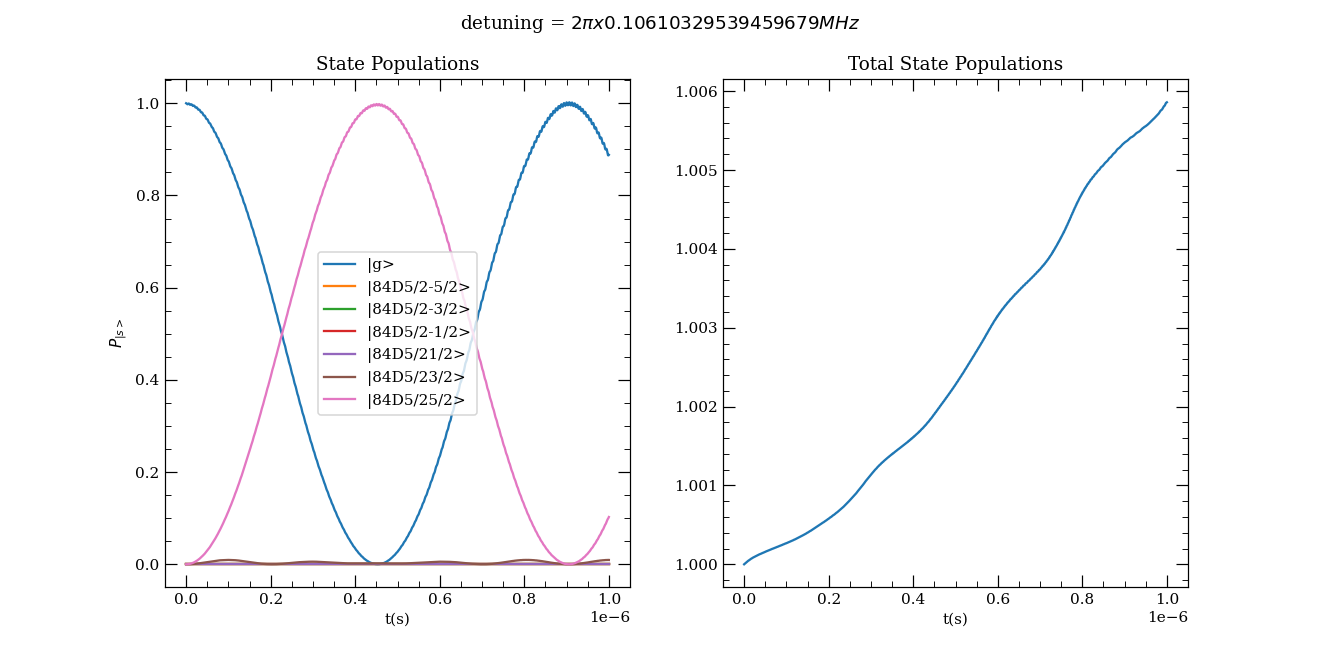

<IPython.core.display.Javascript object>


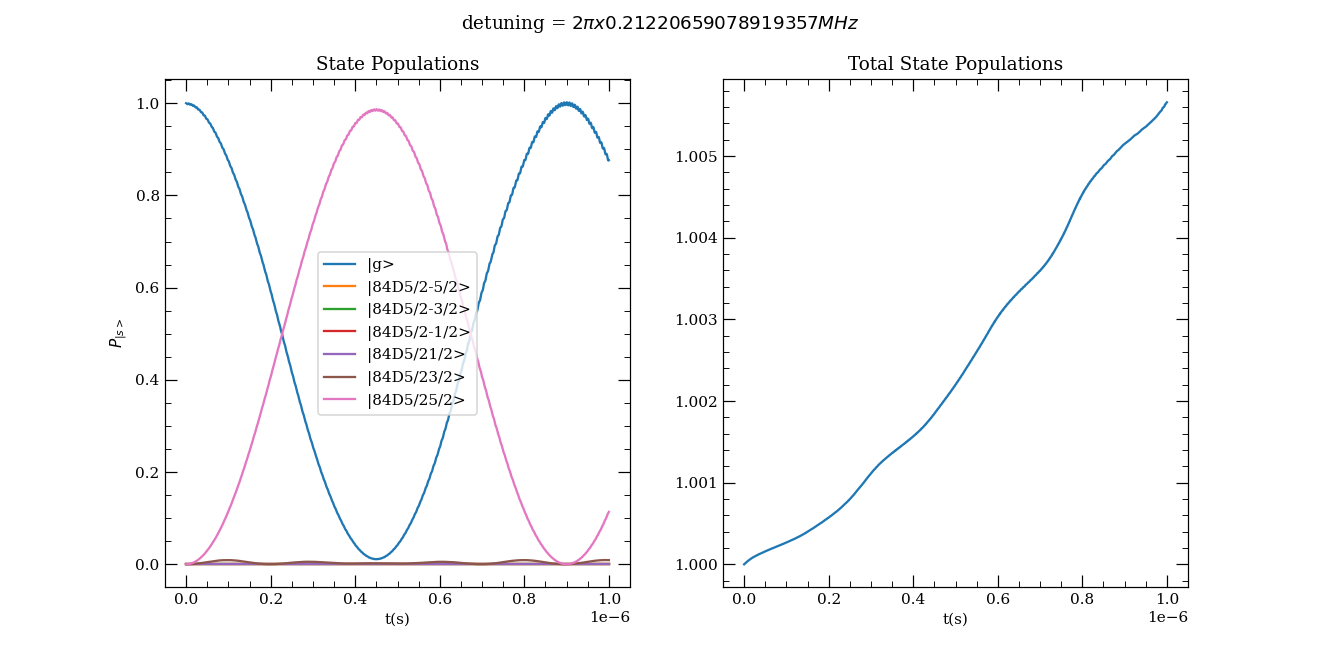

<IPython.core.display.Javascript object>


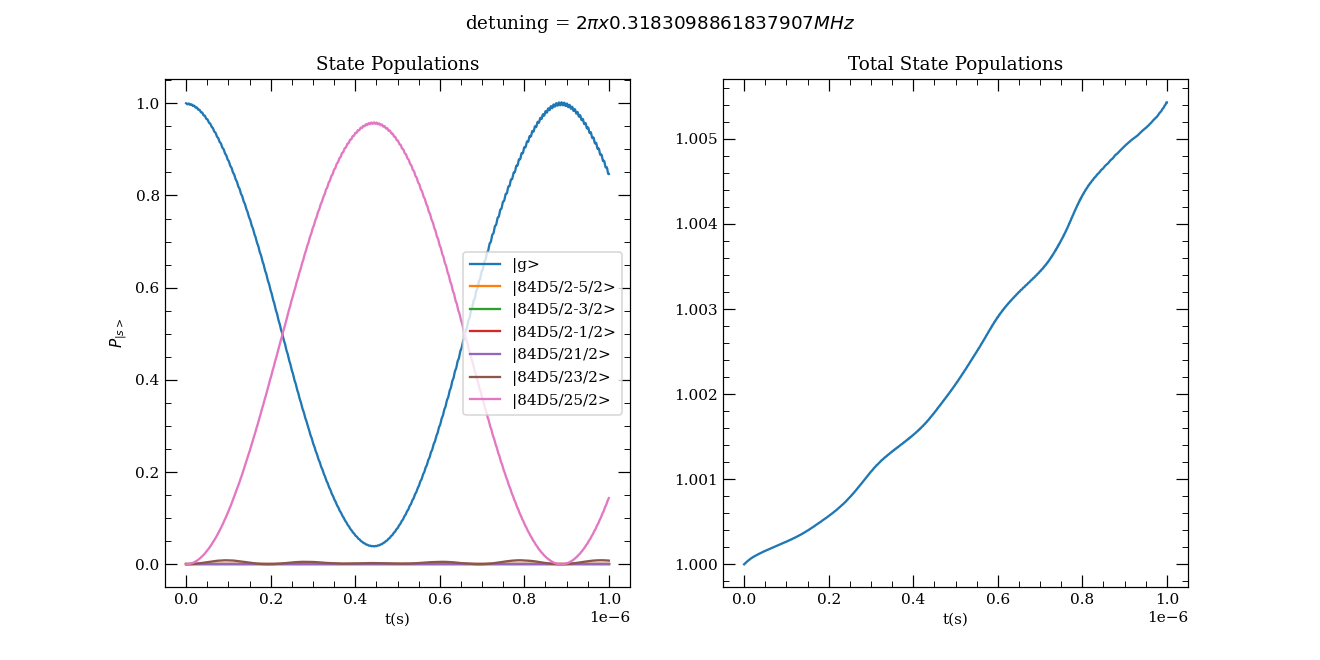

<ipython-input-47-524d898a3df4>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,2,figsize = (12,6))


<IPython.core.display.Javascript object>


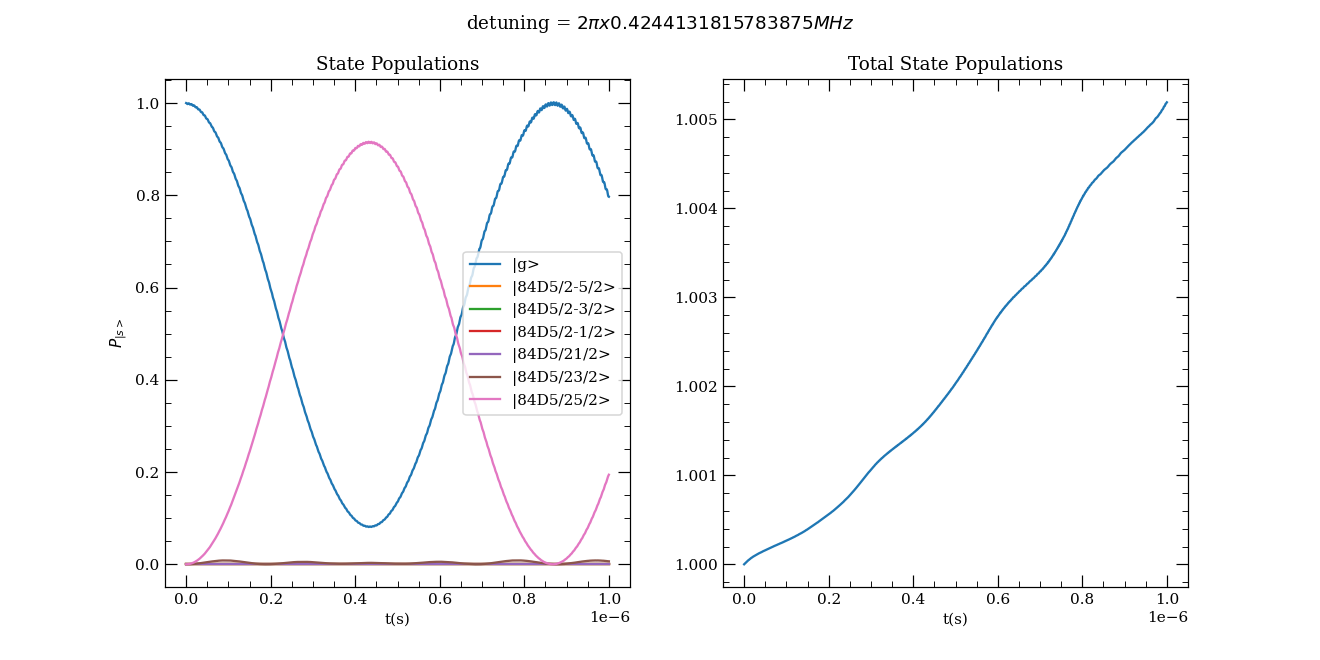

<IPython.core.display.Javascript object>


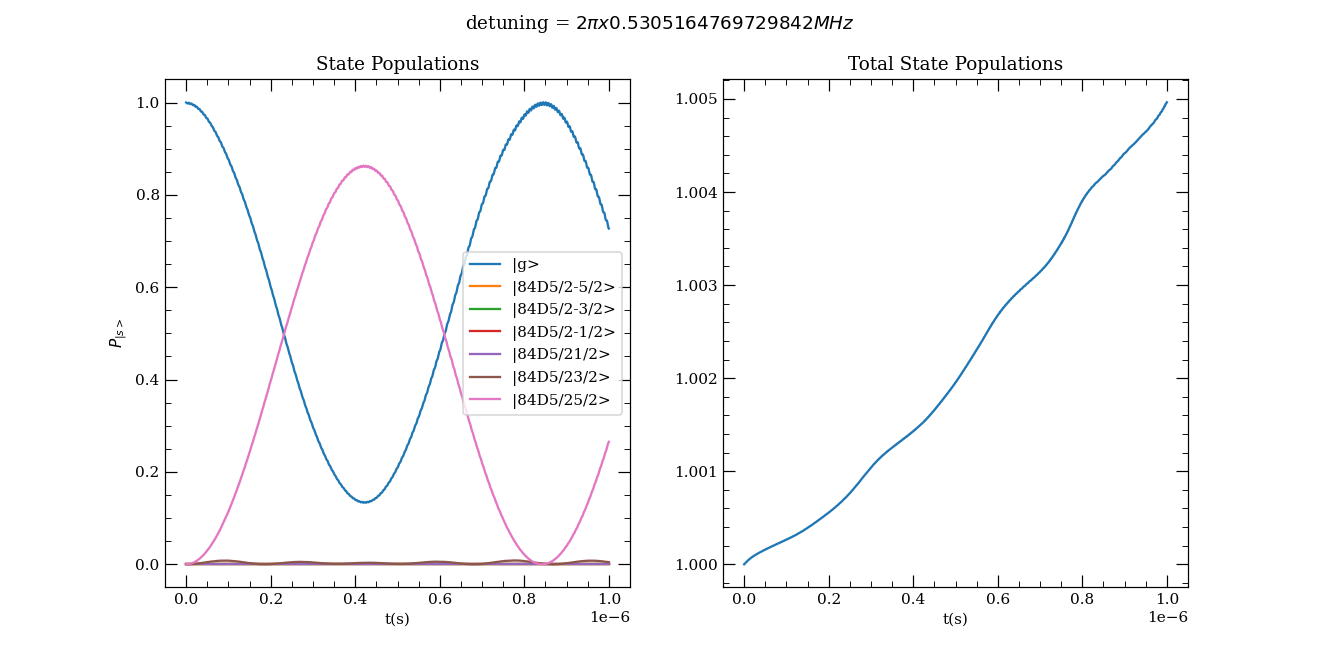

<IPython.core.display.Javascript object>


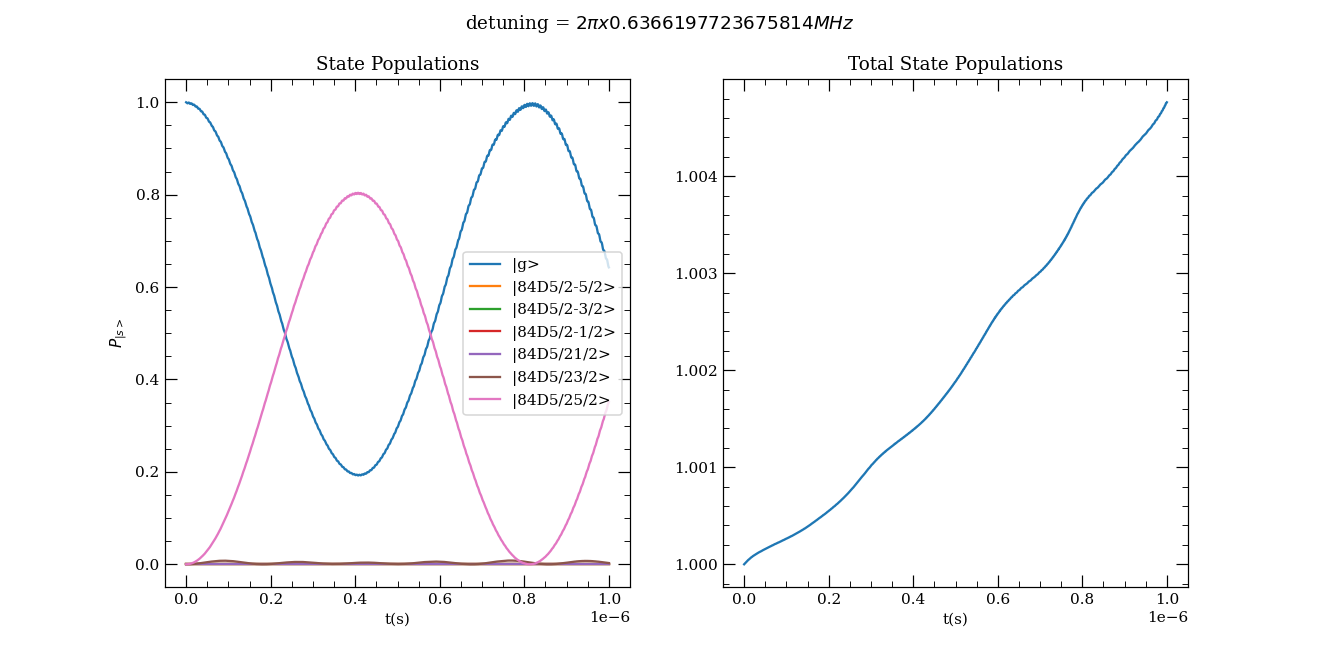

<IPython.core.display.Javascript object>


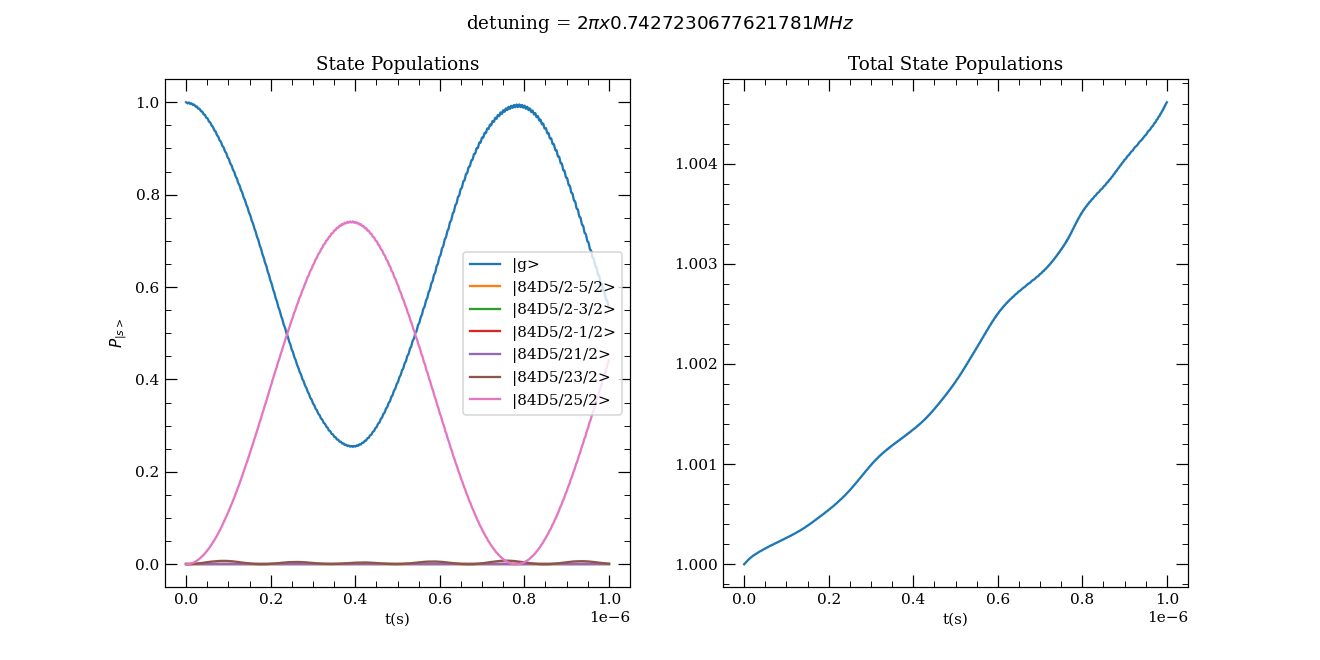

<IPython.core.display.Javascript object>


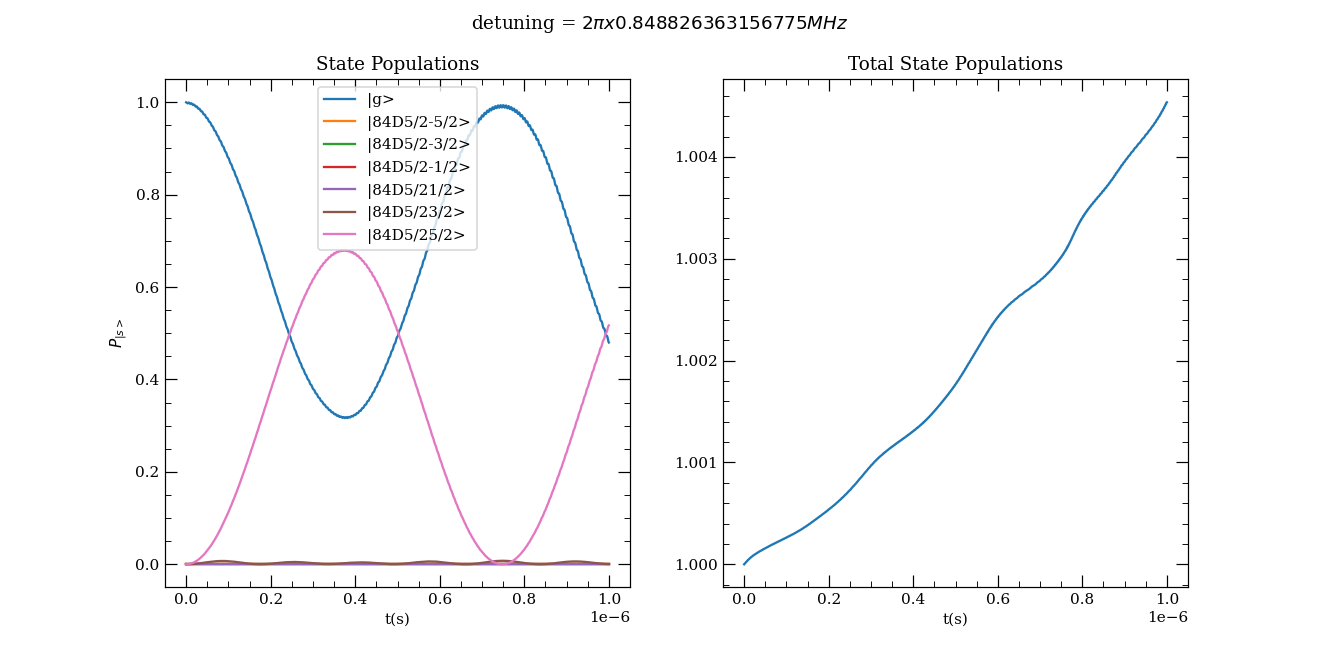

<IPython.core.display.Javascript object>


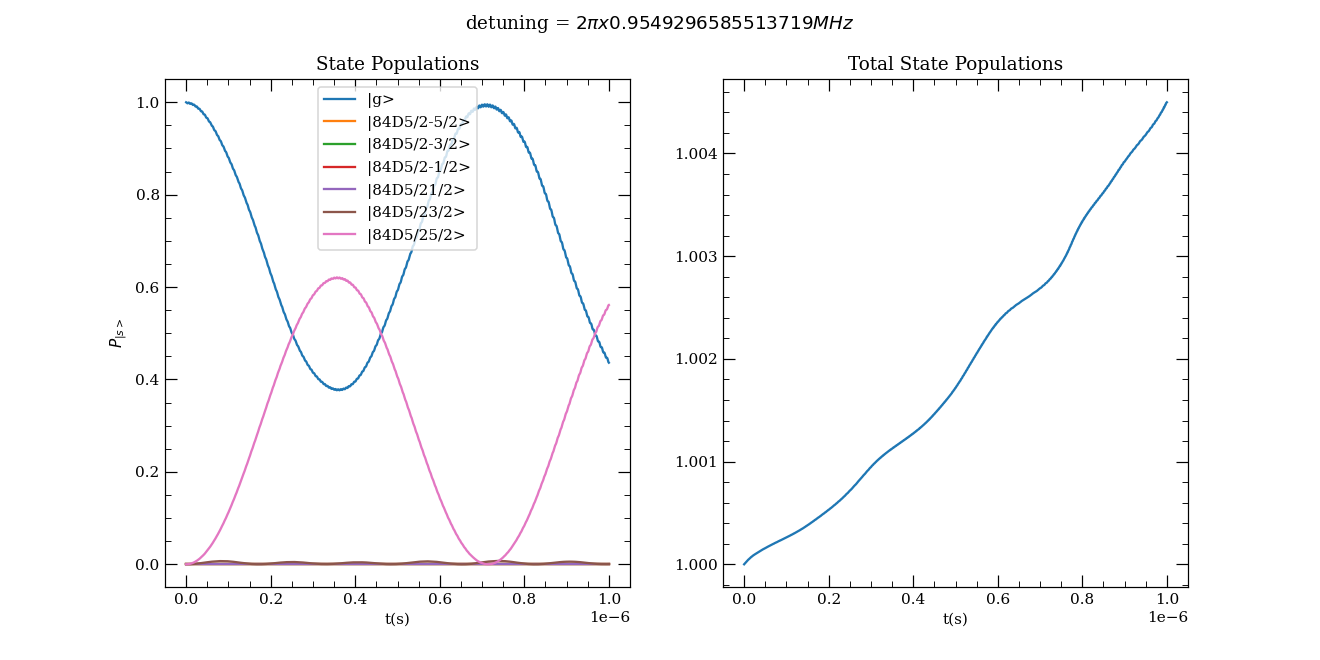

<IPython.core.display.Javascript object>


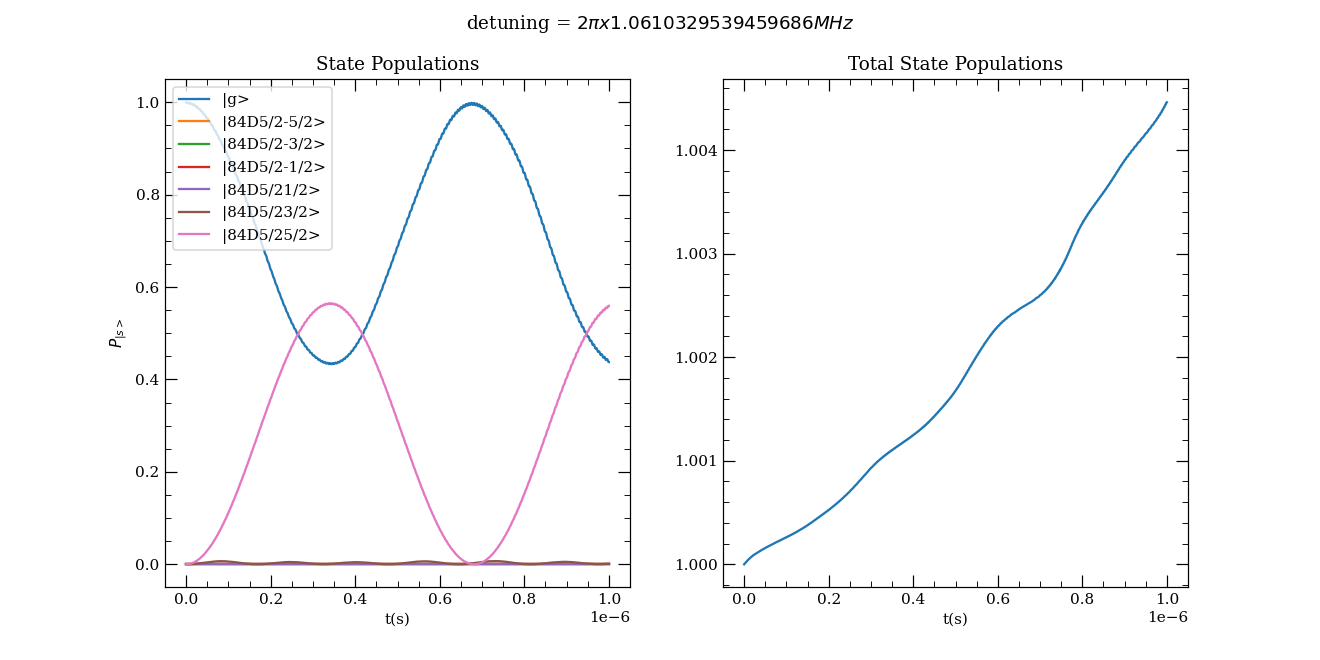

<IPython.core.display.Javascript object>


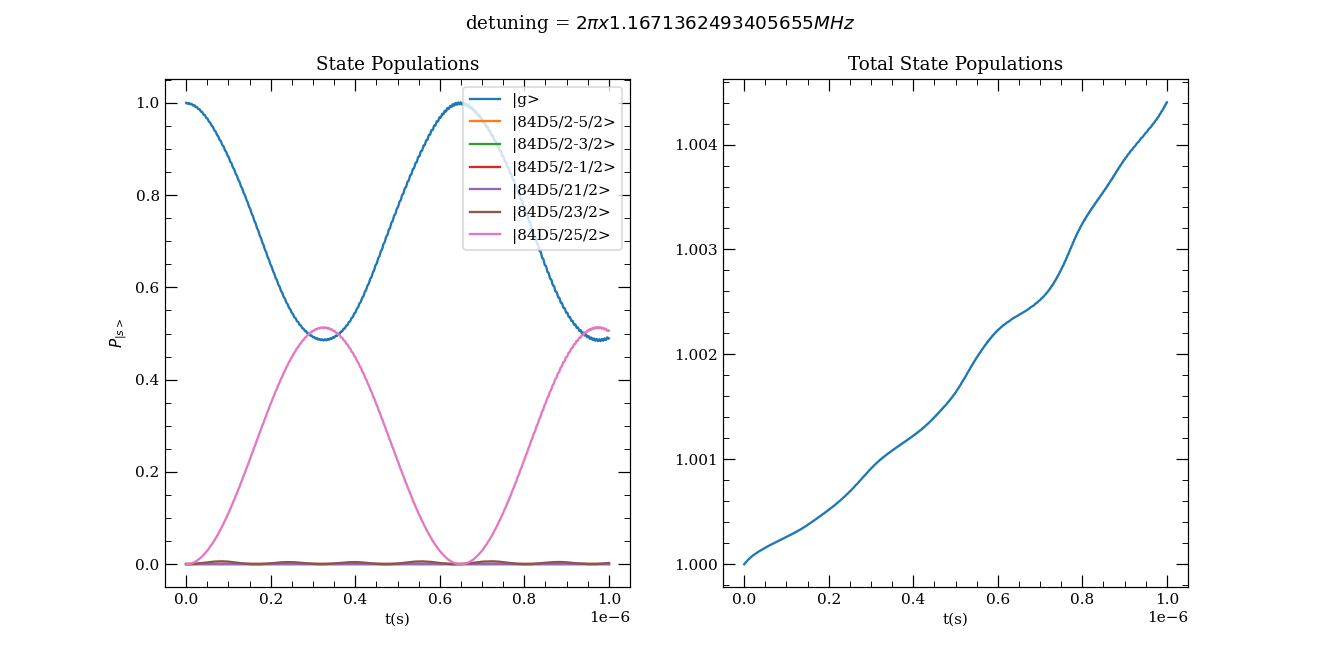

<IPython.core.display.Javascript object>


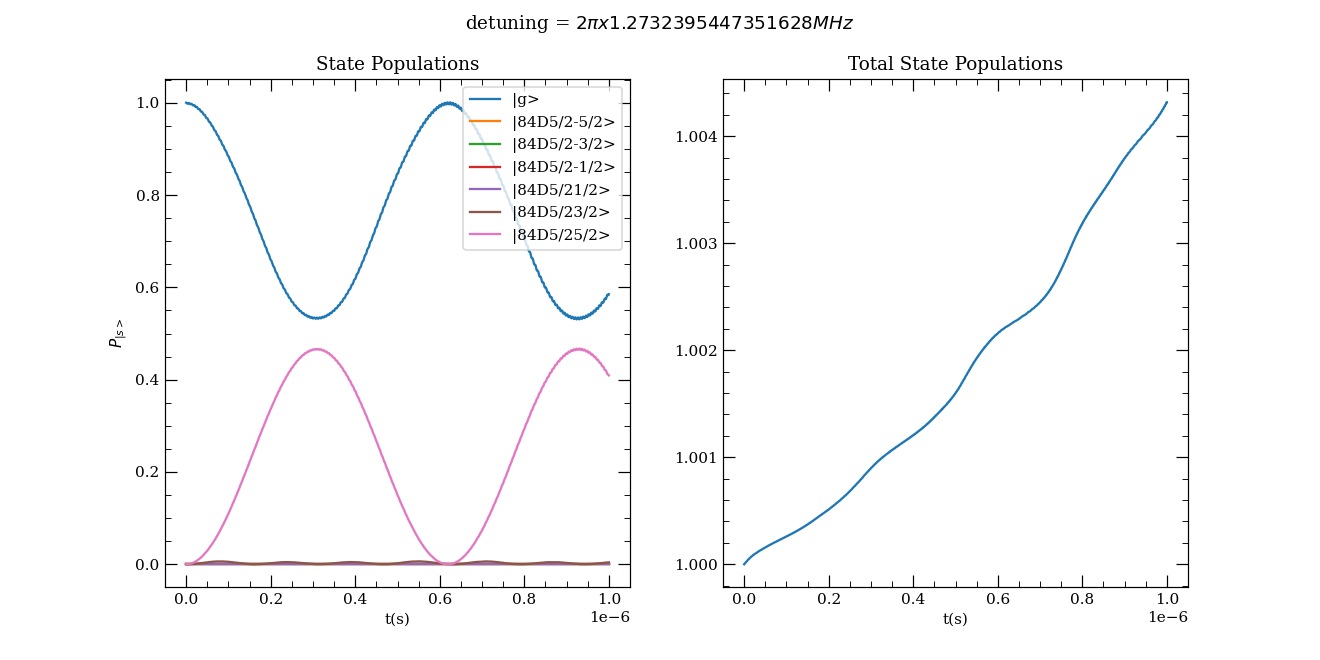

<IPython.core.display.Javascript object>


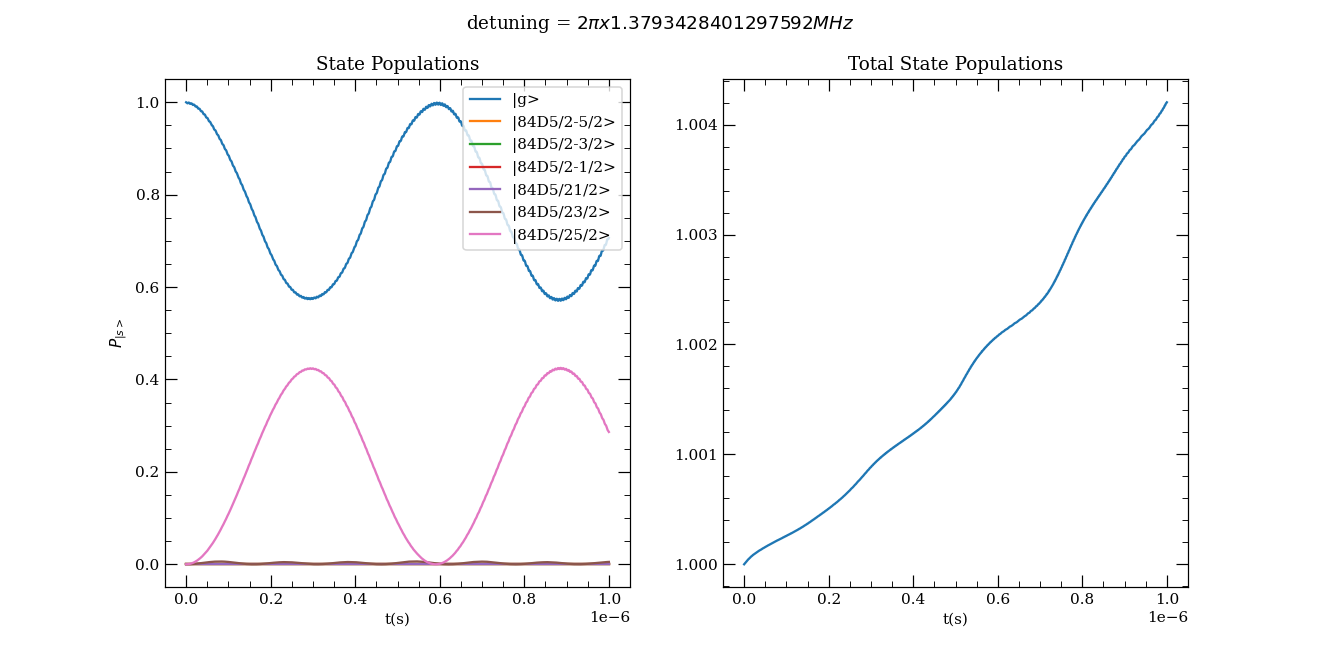

<IPython.core.display.Javascript object>


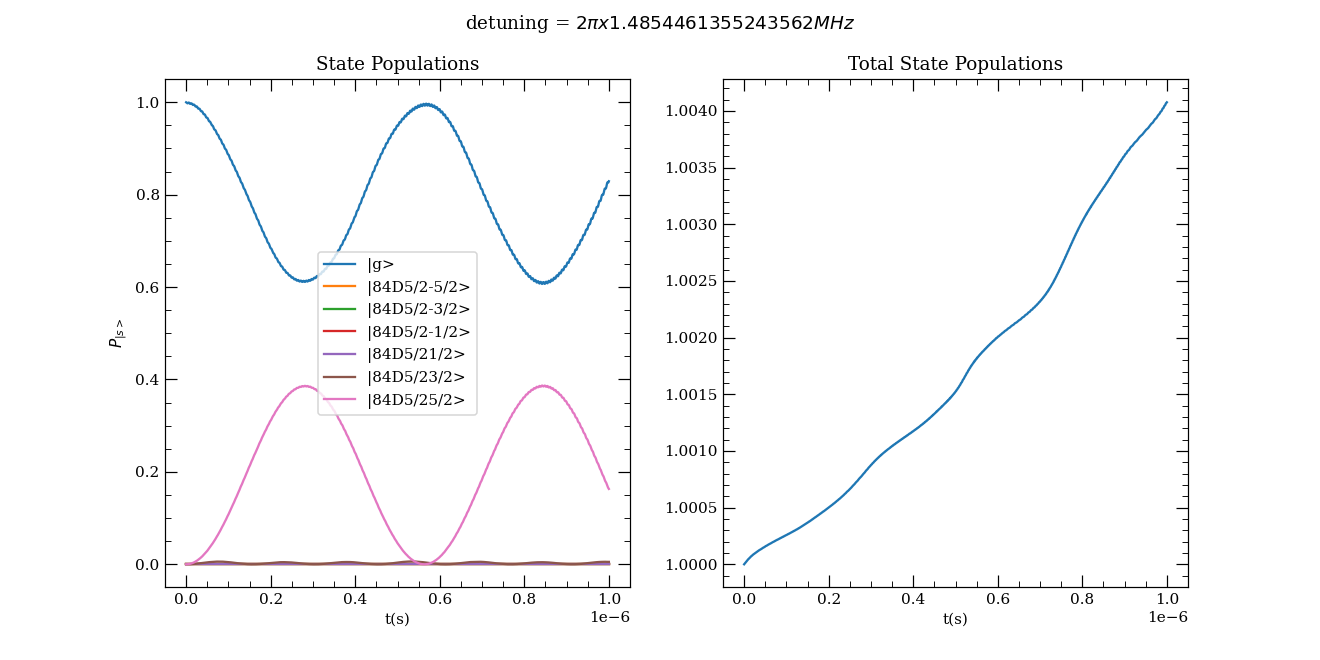

<IPython.core.display.Javascript object>


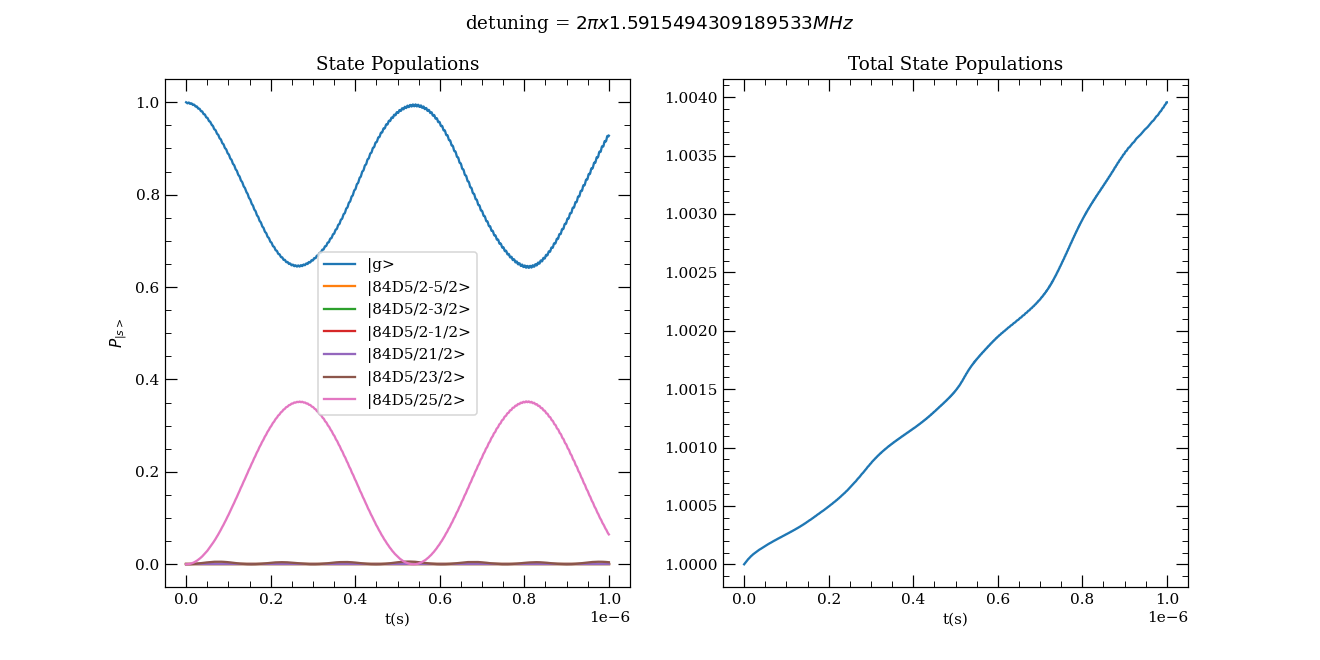

In [47]:
ts = np.linspace(0,1e-6,1000)
detunings = np.linspace(-10e6,10e6,31)
P_r = np.zeros((len(detunings),len(mr_list)),dtype=float)
ys = np.zeros((len(psi_0),len(detunings),len(ts)),dtype=complex)
for i, detuning in enumerate(detunings):
    for j, mr in enumerate(mr_list):
        H[ryd_ind(mr), ryd_ind(mr)] = little_delta-zeeman_r(bias_B,nr,mr)/hb+detuning
    sol = solve_ivp(
        lambda t, y : psi_sch(t, y, H),
        (min(ts),max(ts)),
        psi_0,
        t_eval = ts
    )
    ys[:,i,:] = sol.y
    # P_r[i,:] = np.abs(sol.y[-len(mr_list):,1])**2
    fig,ax = plt.subplots(1,2,figsize = (12,6))
    ax[0].plot(ts,np.abs(sol.y[0])**2,label = f"|g>")
    for mr in mr_list:
        ax[0].plot(ts,np.abs(sol.y[ryd_ind(mr)])**2,label = f"|{nr}D5/2{int(2*mr)}/2>")
    ax[0].legend()
    ax[0].set_title(f"State Populations")
    ax[1].set_title(f"Total State Populations")
    ax[0].set_xlabel(f"t(s)")
    ax[0].set_ylabel("$P_{|s>}$")
    ax[1].plot(ts,(np.abs(sol.y)**2).sum(0))
    ax[1].set_xlabel(f"t(s)")
    fig.suptitle(f"detuning = $2\pi x {detuning/(2*pi)*1e-6}MHz$")
    fig.show()

In [50]:
print(zeeman_r(bias_B,nr,5/2)/h*1e-6)
print(zeeman_r(bias_B,nr,3/2)/h*1e-6)
print(H[ryd_ind(3/2),ryd_ind(3/2)],H[ryd_ind(5/2),ryd_ind(5/2)])

12.596620538742503
7.557972323245501
(41658760.435657404+0j) (10000000+0j)


In [44]:
for i, detuning in enumerate(detunings):
    for j, mr in enumerate(mr_list):
        H[ryd_ind(mr), ryd_ind(mr)] = H[ryd_ind(mr), ryd_ind(mr)] = little_delta-zeeman_r(bias_B,nr,mr)/hb+detuning
        print(detuning)
        print(H[ryd_ind(mr), ryd_ind(mr)])
        print(little_delta-zeeman_r(bias_B,nr,mr)/hb)
        print(little_delta-zeeman_r(bias_B,nr,mr)/hb+detuning)

-10000000.0
(148293802.178287+0j)
158293802.178287
148293802.178287
-10000000.0
(116635041.74262959+0j)
126635041.74262959
116635041.74262959
-10000000.0
(84976281.30697219+0j)
94976281.30697219
84976281.30697219
-10000000.0
(53317520.8713148+0j)
63317520.8713148
53317520.8713148
-10000000.0
(21658760.435657404+0j)
31658760.435657404
21658760.435657404
-10000000.0
(-10000000+0j)
0.0
-10000000.0
-9333333.333333334
(148960468.84495366+0j)
158293802.178287
148960468.84495366
-9333333.333333334
(117301708.40929626+0j)
126635041.74262959
117301708.40929626
-9333333.333333334
(85642947.97363886+0j)
94976281.30697219
85642947.97363886
-9333333.333333334
(53984187.537981465+0j)
63317520.8713148
53984187.537981465
-9333333.333333334
(22325427.10232407+0j)
31658760.435657404
22325427.10232407
-9333333.333333334
(-9333333.333333334+0j)
0.0
-9333333.333333334
-8666666.666666666
(149627135.51162034+0j)
158293802.178287
149627135.51162034
-8666666.666666666
(117968375.07596292+0j)
126635041.74262959

<IPython.core.display.Javascript object>


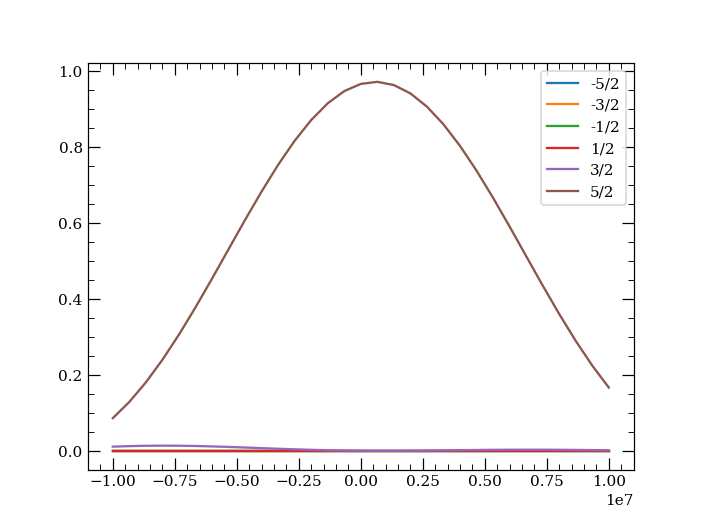

In [48]:
t_ind = np.where(abs(ts - 0.407e-6) < 0.0005e-6)
P_r = np.abs(ys[-len(mr_list):,:,t_ind[0]])**2
fig,ax = plt.subplots(1,1)
for i, mr in enumerate(mr_list):
    ax.plot(detunings,P_r[i,:],label = f"{int(2*mr)}/2")
ax.legend()
fig.show()

In [32]:
t_ind = np.where(abs(ts - 0.407e-6) < 0.0005e-6)
print(t_ind)

(array([407], dtype=int32),)


In [31]:
def sq_cos(x, omega, a):
    return a*np.cos(omega*x/2)
xdat = ts
ydat = np.abs(sol.y[0])**2
guess = [
    2*pi*5e6,
    1.0
]

popt,pcov = curve_fit(sq_cos,xdat,ydat,p0=guess)
perr=np.sqrt(np.diag(pcov))

print(f"{popt[0]/(2*pi)*1e-6}MHz")
t_pi = pi/popt[0]

4.8743345239273195MHz


In [13]:
d_AC = np.zeros(len(mr_list),dtype=float)

for fe in f_list:
    for me in me_list:
        for i, mr in enumerate(mr_list):
            O1 = Oge[fe,me]
            O2 = Oer[fe,me,i]
            d_AC[i] += ((O1*O1.conjugate() - O2*O2.conjugate())/(4*delta[fe])).real

In [32]:
print(t_pi)

1.0257810528710758e-07


In [15]:
for i, mr in enumerate(mr_list):
    print(mr, d_AC[i])

-2.5 -6026058.3021518625
-1.5 -6026058.3021518625
-0.5 -5489517.762406168
0.5 -3611625.873296232
1.5 -1197193.4444406005
2.5 -660652.9046949055
